In [176]:
%matplotlib inline
import matplotlib.pyplot as plt
import sklearn
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from typing import Dict, Tuple, Callable
from sklearn import svm
from sklearn.model_selection import cross_val_score
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import pandas as pd
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

### Exercise 1

1. Pirate Attacks

Use KNN, Naive Bayes and SVM on the ‘Pirate Attacks’ dataset to predict pirate attack success:

- Clean and preprocess data using a one-hot-encoder for categorical variables.
- Run the three models on the data.
- Have you noticed something strange? There is a “data leakage” here..

- Identify the feature(s) that are giving away the result!
- Run you models again. Which model is the best in predicting attacks?

In [132]:
data = pd.read_csv('pirate_data.csv')
data.head()

,Unnamed: 0,DATETIME (LOCAL),DATETIME (UTC),DATE (LT),DATE (UTC),REGION,COUNTRY,INCIDENT TYPE,VESSEL TYPE,MAERSK?,VESSEL ACTIVITY LOCATION,LAT,LONG,TIMEZONE,TIME OF DAY,ATTACKS,ATTACK SUCCESS
0,1,2016-01-30 23:34:00,2016-01-30 22:34:00,2016-01-30,2016-01-30,WEST AFRICA,NIGERIA,"FAILED ATTACK, HIJACKING",CONTAINER SHIP,0,OFF SHORE,3.000000,6.250000,Africa/Lagos,EVENING,1,0
1,2,2016-01-29 23:40:00,2016-01-29 22:40:00,2016-01-29,2016-01-29,WEST AFRICA,NIGERIA,KIDNAP/RANSOM AT SEA,PRODUCT TANKER,0,OFF SHORE,2.500000,5.750000,Africa/Lagos,EVENING,1,1
2,3,2016-01-28 03:00:00,2016-01-28 02:00:00,2016-01-28,2016-01-28,SOUTH ASIA,INDIA,"FAILED ATTACK, ROBBERY",PRODUCT TANKER,0,ANCHORAGE,22.816667,70.116667,Asia/Kolkata,NIGHT,1,0
3,4,NaN,NaN,2016-01-27,2016-01-27,HORN OF AFRICA/ GULF OF ADEN,SOMALIA,SUSPICIOUS ACTIVITY AT SEA,NaN,0,OFF SHORE,13.998747,54.112792,Asia/Riyadh,UNKNOWN,1,0
4,5,2016-01-25 23:55:00,2016-01-25 22:55:00,2016-01-25,2016-01-25,SOUTH AMERICA,VENEZUELA,THEFT AT ANCHORAGE,GENERAL CARGO VESSEL,0,ANCHORAGE,10.267500,-63.432500,America/Caracas,EVENING,1,1


### Cleaning Data - dropping columns and grouping

In [133]:
data = data.drop(columns=['Unnamed: 0'])

In [134]:
# we observe that ATTACKS are all 1 so we can remove this column
data = data.drop(columns=['ATTACKS'])

In [135]:
#remove more redundant columns
#remove incident type since it doesn't explain anything, this is value that appears AFTER an attack and therefore
#is not helpful for predicting
data = data.drop(columns=['DATETIME (LOCAL)','DATE (LT)','TIMEZONE','LAT','LONG','INCIDENT TYPE'])


In [136]:
data['VESSEL ACTIVITY LOCATION'].value_counts()

OFF SHORE    421
ANCHORAGE    198
BERTH         57
Name: VESSEL ACTIVITY LOCATION, dtype: int64

In [137]:
data['TIME OF DAY'].value_counts()

NIGHT        271
UNKNOWN      178
MORNING      153
EVENING      125
AFTERNOON     75
Name: TIME OF DAY, dtype: int64

In [138]:
#there are too many vessel types to convert to columns so let's simplify into:
#1) Bulk container, 2) product tanker, 3) container ship, 4) other


data['VESSEL TYPE'].loc[~data['VESSEL TYPE'].isin(['BULK CARRIER','PRODUCT TANKER','CONTAINER SHIP'])] = 'OTHER'


In [139]:
data['VESSEL ACTIVITY LOCATION'].value_counts()

OFF SHORE    421
ANCHORAGE    198
BERTH         57
Name: VESSEL ACTIVITY LOCATION, dtype: int64

### Change unknown data to values based on assumptions

In [140]:

#set all unknown time of days to EVENING since evening is the most likely time of attack
data.loc[data['TIME OF DAY']=='UNKNOWN', 'TIME OF DAY'] = data['TIME OF DAY'].value_counts().index[0]
    

In [141]:
#let's also assume that all NaN 'Vessel Activity Location' is 'OFFSHORE, which is the most common location.

data['VESSEL ACTIVITY LOCATION'].loc[data['VESSEL ACTIVITY LOCATION'].isna()] = data['VESSEL ACTIVITY LOCATION'].value_counts().index[0]



In [142]:
#look at remaining data columns that have na's . 
data.isna().sum()

DATETIME (UTC)              220
DATE (UTC)                    0
REGION                        0
COUNTRY                       0
VESSEL TYPE                   0
MAERSK?                       0
VESSEL ACTIVITY LOCATION      0
TIME OF DAY                   0
ATTACK SUCCESS                0
dtype: int64

In [116]:
#data.dropna(subset=['VESSEL TYPE','VESSEL ACTIVITY LOCATION','TIME OF DAY'])

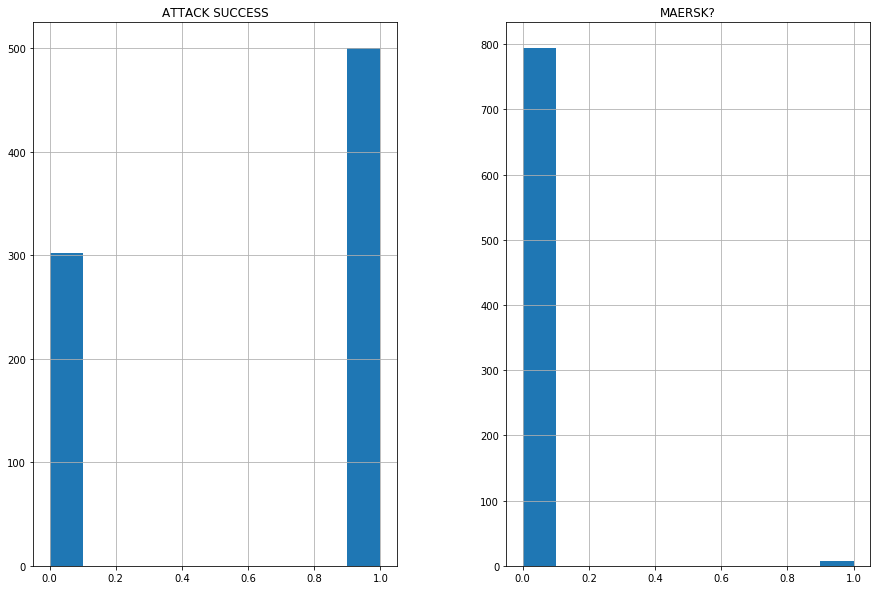

In [117]:
data.hist(figsize = (15,10));

In [145]:
data = data.drop(columns=['DATETIME (UTC)'])

In [148]:
data

,DATE (UTC),REGION,COUNTRY,VESSEL TYPE,MAERSK?,VESSEL ACTIVITY LOCATION,TIME OF DAY,ATTACK SUCCESS
0,2016-01-30,WEST AFRICA,NIGERIA,CONTAINER SHIP,0,OFF SHORE,EVENING,0
1,2016-01-29,WEST AFRICA,NIGERIA,PRODUCT TANKER,0,OFF SHORE,EVENING,1
2,2016-01-28,SOUTH ASIA,INDIA,PRODUCT TANKER,0,ANCHORAGE,NIGHT,0
3,2016-01-27,HORN OF AFRICA/ GULF OF ADEN,SOMALIA,OTHER,0,OFF SHORE,NIGHT,0
4,2016-01-25,SOUTH AMERICA,VENEZUELA,OTHER,0,ANCHORAGE,EVENING,1
...,...,...,...,...,...,...,...,...
797,2016-06-04,SOUTH EAST ASIA,MALAYSIA,PRODUCT TANKER,0,OFF SHORE,NIGHT,0
798,2016-06-03,WEST AFRICA,NIGERIA,OTHER,0,OFF SHORE,NIGHT,1
799,2016-06-02,SOUTH EAST ASIA,MALAYSIA,OTHER,0,OFF SHORE,NIGHT,1
800,2016-06-01,WEST AFRICA,NIGERIA,OTHER,0,OFF SHORE,EVENING,1


In [ ]:
#pipeline
#The numeric data is standard-scaled
#numeric_transformer = Pipeline(steps=[('scaler', MinMaxScaler())])
#
#while the categorical data is one-hot encoded
#categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

#preprocessor = ColumnTransformer(
#    transformers=[
#        ('num', numeric_transformer, numeric_features),
#        ('cat', categorical_transformer, categorical_features)])

In [152]:
data['DATE (UTC)'] = pd.to_datetime(data['DATE (UTC)'])

In [160]:
data['MONTH'] = data['DATE (UTC)'].apply(lambda x: x.month)


In [162]:
data.head()

,DATE (UTC),REGION,COUNTRY,VESSEL TYPE,MAERSK?,VESSEL ACTIVITY LOCATION,TIME OF DAY,ATTACK SUCCESS,MONTH
0,2016-01-30,WEST AFRICA,NIGERIA,CONTAINER SHIP,0,OFF SHORE,EVENING,0,1
1,2016-01-29,WEST AFRICA,NIGERIA,PRODUCT TANKER,0,OFF SHORE,EVENING,1,1
2,2016-01-28,SOUTH ASIA,INDIA,PRODUCT TANKER,0,ANCHORAGE,NIGHT,0,1
3,2016-01-27,HORN OF AFRICA/ GULF OF ADEN,SOMALIA,OTHER,0,OFF SHORE,NIGHT,0,1
4,2016-01-25,SOUTH AMERICA,VENEZUELA,OTHER,0,ANCHORAGE,EVENING,1,1


In [163]:
data = data.drop(columns=['DATE (UTC)'])

In [164]:
data.head()

,REGION,COUNTRY,VESSEL TYPE,MAERSK?,VESSEL ACTIVITY LOCATION,TIME OF DAY,ATTACK SUCCESS,MONTH
0,WEST AFRICA,NIGERIA,CONTAINER SHIP,0,OFF SHORE,EVENING,0,1
1,WEST AFRICA,NIGERIA,PRODUCT TANKER,0,OFF SHORE,EVENING,1,1
2,SOUTH ASIA,INDIA,PRODUCT TANKER,0,ANCHORAGE,NIGHT,0,1
3,HORN OF AFRICA/ GULF OF ADEN,SOMALIA,OTHER,0,OFF SHORE,NIGHT,0,1
4,SOUTH AMERICA,VENEZUELA,OTHER,0,ANCHORAGE,EVENING,1,1


In [165]:
cat_columns = ["REGION", "COUNTRY",'VESSEL TYPE',"VESSEL ACTIVITY LOCATION","TIME OF DAY"]

In [166]:
#datap is processed data
datap = pd.get_dummies(data, prefix_sep="_",
                              columns=cat_columns)

In [170]:
datap.head()

,MAERSK?,ATTACK SUCCESS,MONTH,REGION_CARIBBEAN,REGION_EAST AFRICA,REGION_EUROPE,REGION_HORN OF AFRICA/ GULF OF ADEN,REGION_MIDDLE EAST,REGION_NORTH AFRICA,REGION_NORTH AMERICA,...,VESSEL TYPE_CONTAINER SHIP,VESSEL TYPE_OTHER,VESSEL TYPE_PRODUCT TANKER,VESSEL ACTIVITY LOCATION_ANCHORAGE,VESSEL ACTIVITY LOCATION_BERTH,VESSEL ACTIVITY LOCATION_OFF SHORE,TIME OF DAY_AFTERNOON,TIME OF DAY_EVENING,TIME OF DAY_MORNING,TIME OF DAY_NIGHT
0,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,1,0,0
1,0,1,1,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,1,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,1
3,0,0,1,0,0,0,1,0,0,0,...,0,1,0,0,0,1,0,0,0,1
4,0,1,1,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,1,0,0


### Use KNN, Naive Bayes and SVM on the ‘Pirate Attacks’ dataset to predict pirate attack success

In [190]:
X = datap.loc[:, datap.columns != 'ATTACK SUCCESS']

In [191]:
y =datap['ATTACK SUCCESS'].values

In [202]:
# create training and testing data sets which we will use later after we select a model from k-1 cross validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(641, 81) (641,)
(161, 81) (161,)


In [203]:
#we will apply a scaler to our new data set, since some coefficients have high numbers relative to others which are
#logistical and have only a 1 or 0. Specifically, we will use the MinMax scaling option: (X-Xmin/Xmax - Xmin)
#
scaler = MinMaxScaler()
X_train_sc = scaler.fit_transform(X_train)
X_train_sc = pd.DataFrame(X_train_sc, columns = X_train.columns)
X_test_sc = scaler.transform(X_test)
X_test_sc = pd.DataFrame(X_test_sc, columns = X_test.columns)

### KNN model

In [204]:
# fit a KNN Classifier model then apply it within a k-1 cross validation set, split into 5 parts

knn = KNeighborsClassifier(n_neighbors = 3)
cv_knn = cross_val_score(estimator = knn, X=X_train_sc, y=y_train.ravel(),cv=5)

# Fit the classifier to the data
knn.fit(X_train_sc,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [205]:
#check accuracy of our model on the test data and confirm it's working
knn.score(X_test, y_test)

0.5652173913043478

In [206]:
#creating a loop for KNN model which records results in table
# we change the C paramter, which influences the effect that the penalty function has
neighbr=[3,6,10]
model_scores = pd.DataFrame(columns = ['neighbours', 'Mean'])

model_scores['neighbours'] = neighbr 
for i in neighbr:
    knn = KNeighborsClassifier(n_neighbors = 3)
    cv_knn = cross_val_score(estimator = knn, X=X_train_sc, y=y_train.ravel(),cv=5)
    model_scores.loc[model_scores['neighbours'] == i, "Mean"] = cv_knn.mean()
    
model_scores

,neighbours,Mean
0,3,0.61317
1,6,0.61317
2,10,0.61317


In [287]:
from sklearn.model_selection import GridSearchCV
#create new a knn model
knn2 = KNeighborsClassifier(n_neighbors = 3)
#create a dictionary of all values we want to test for n_neighbors
param_grid = {"n_neighbors": [3, 4,5,6,7,50]}
#use gridsearch to test all values for degrees
knn_gscv = GridSearchCV(knn2, param_grid, cv=5)
#fit model to data
knn_gscv.fit(X_train_sc, y_train.ravel())

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=3, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'n_neighbors': [3, 4, 5, 6, 7, 50]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [288]:
knn_gscv.best_score_

0.6271450858034321

### Naive Bayes model

In [258]:
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB(binarize=0.0)
cv_bnb = cross_val_score(estimator = bnb, X=X_train_sc, y=y_train.ravel(),cv=5)

# Fit the classifier to the data
bnb.fit(X_train_sc,y_train)


BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [259]:
#check accuracy of our model on the test data and confirm it's working
bnb.score(X_test, y_test)

0.6149068322981367

In [277]:
from sklearn.model_selection import GridSearchCV
#create new a knn model
bnb2 = BernoulliNB()
#create a dictionary of all values we want to test for n_neighbors
param_grid = {"degree": [1,2,3,4,5,6,7,8,9]}
#use gridsearch to test all values for degrees
bnb_gscv = GridSearchCV(bnb2, param_grid, cv=5)
#fit model to data
bnb_gscv.fit(X_train_sc, y_train.ravel())

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto', kernel='poly', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'degree': [1, 2, 3, 4, 5, 6, 7, 8, 9]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [278]:
bnb_gscv.best_score_

0.6271450858034321

In [289]:
bnb_gscv.get_params

<bound method BaseEstimator.get_params of GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto', kernel='poly', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'degree': [1, 2, 3, 4, 5, 6, 7, 8, 9]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)>

### SVM Model

In [255]:
from sklearn.svm import SVC

svc = SVC(kernel='poly', degree=8, gamma='auto')
cv_svc = cross_val_score(estimator = svc, X=X_train_sc, y=y_train.ravel(),cv=5)

# Fit the classifier to the data
svc.fit(X_train_sc,y_train)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=8, gamma='auto', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [256]:
#check accuracy of our model on the test data and confirm it's working
svc.score(X_test, y_test)

0.6086956521739131

In [322]:
from sklearn.model_selection import GridSearchCV
#create new a knn model
svc2 = SVC(kernel='poly', gamma='auto',probability=True)
#create a dictionary of all values we want to test for n_neighbors
param_grid = {"degree": [1, 2,3,4,5]}
#use gridsearch to test all values for degrees
svc_gscv = GridSearchCV(svc2, param_grid, cv=5)
#fit model to data
svc_gscv.fit(X_train_sc, y_train.ravel())

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto', kernel='poly', max_iter=-1,
                           probability=True, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None, param_grid={'degree': [1, 2, 3, 4, 5]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [323]:
svc_gscv.best_score_

0.6271450858034321

In [324]:
svc_gscv.best_estimator_

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=1, gamma='auto', kernel='poly',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

### Applying our best model to the Train Data Set and not the K-1 CV set

In [325]:
bnb3 = svc_gscv.best_estimator_ #SVC(kernel='poly', gamma='auto', degree=10, probability=True)

bnb3.fit(X_train, y_train)

y_pred = bnb3.predict_proba(X_test)



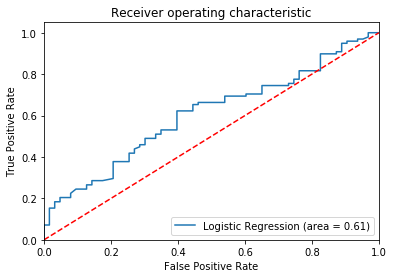

In [326]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
bayes_roc_auc = roc_auc_score(y_test, bnb3.predict_proba(X_test)[:,1])
fpr, tpr, thresholds = roc_curve(y_test, bnb3.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % bayes_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

([array([  0., 149.,   5.,   0.,   0.,   0.,   0.,   6.,   0.,   1.]),
  array([  1.,   0.,   6.,   0.,   0.,   0.,   0.,   5., 149.,   0.])],
 array([0.29012188, 0.33209751, 0.37407313, 0.41604875, 0.45802438,
        0.5       , 0.54197562, 0.58395125, 0.62592687, 0.66790249,
        0.70987812]),
 <a list of 2 Lists of Patches objects>)

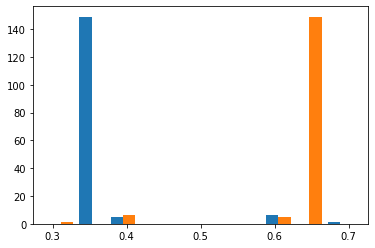

In [327]:
plt.hist(bnb3.predict_proba(X_test))